<h3>Analisis algoritma Machine Learning menggunakan Suport Vektor Machine, Naive Bayes, dan Random Forest untuk menemukan akurasi tinggi dalam penerimaa Vaksin H1N1 kasus Influenza</h3>
<p>Dalam kasus ini penulis memiliki batasan dalam melakukan kasusnya, yang hanya berfokus pada prediksi vaksin H1N1 bukan vaksin flu musiaman atau (seasonal_vaksin)</p>
<p>Tujuanya adalah untuk memberikan analisa mana model machine learning yang terbaik dalam akurasi penerimaan vaksin</p>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score

)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix




<h2>Data Understanding</h2>

In [2]:
data = pd.read_csv('data/H1N1_Flu_Vaccines.csv')
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [3]:
#cek dimensi data dan tipe data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

<Axes: >

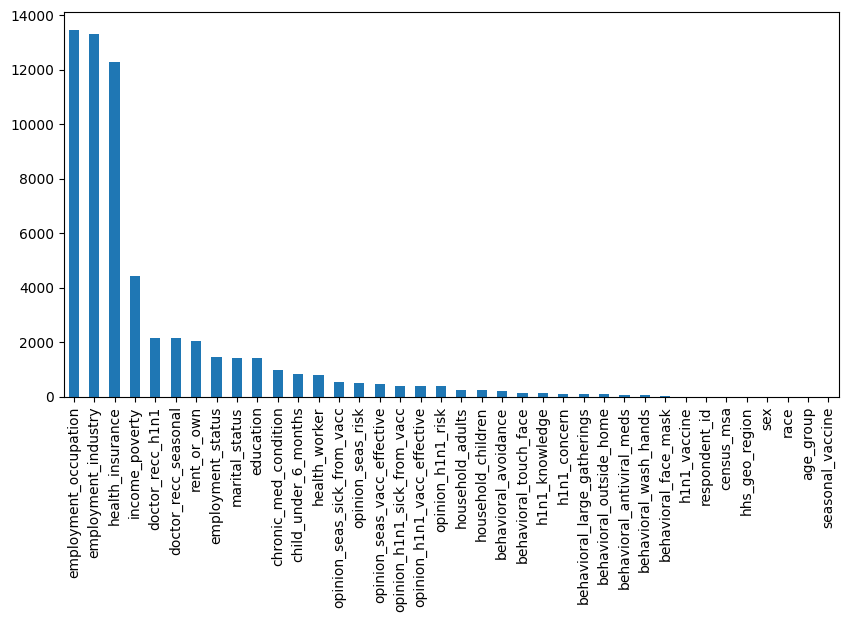

In [4]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

<p>grafik diatas menampilkan kolom yang memiliki missing value</p>

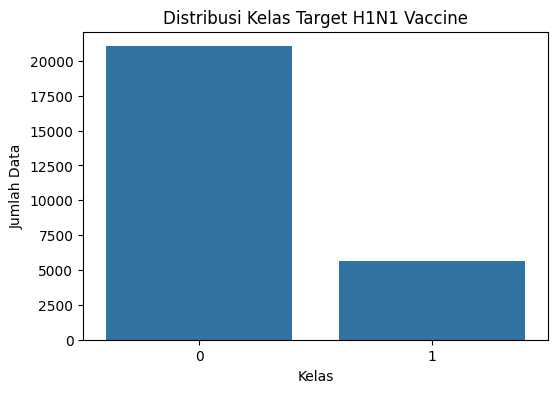

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(x='h1n1_vaccine', data=data)
plt.title('Distribusi Kelas Target H1N1 Vaccine')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.show()


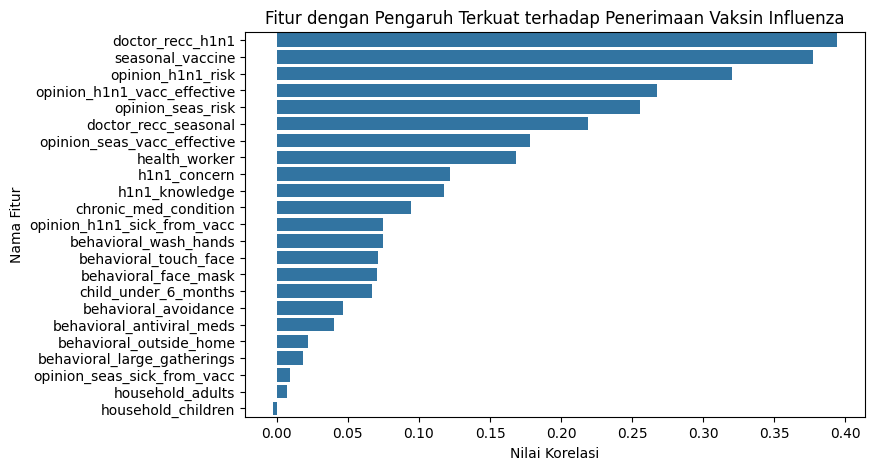

In [64]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])
corr_target = numerical_data.corr()['h1n1_vaccine']

# Urutkan dari yang paling kuat
corr_sorted = corr_target.sort_values(key=abs, ascending=False)
corr_sorted = corr_sorted.drop('h1n1_vaccine')
top_features = corr_sorted
top_features

plt.figure(figsize=(8,5))
sns.barplot(
    x=top_features.values,
    y=top_features.index
)
plt.title('Fitur dengan Pengaruh Terkuat terhadap Penerimaan Vaksin Influenza')
plt.xlabel('Nilai Korelasi')
plt.ylabel('Nama Fitur')
plt.show()

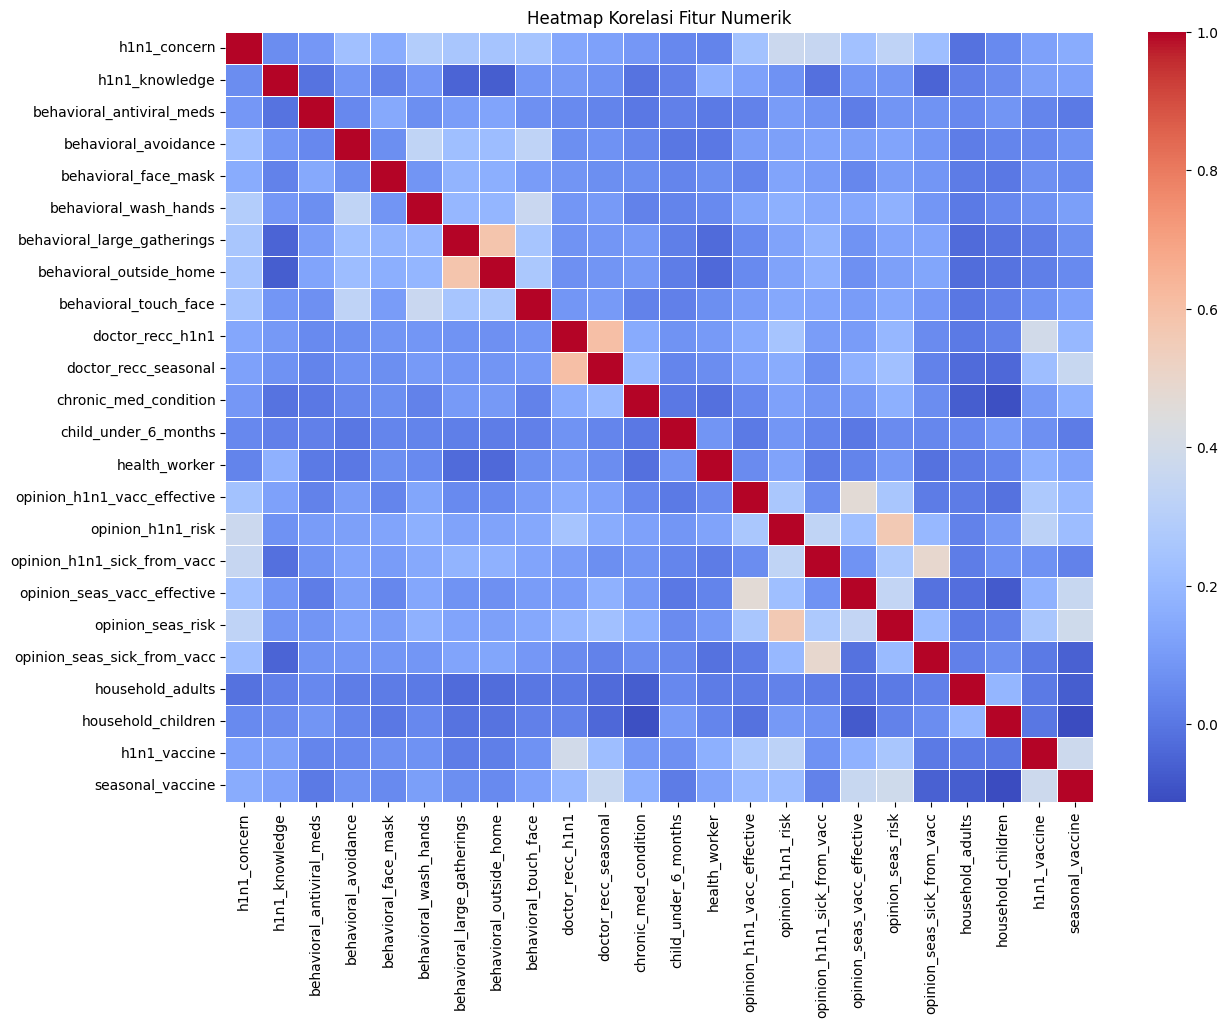

In [ ]:
# numerical_data = data.select_dtypes(include=['int64', 'float64'])

# plt.figure(figsize=(14,10))
# sns.heatmap(
#     numerical_data.corr(),
#     cmap='coolwarm',
#     linewidths=0.5
# )
# plt.title('Heatmap Korelasi Fitur Numerik')
# plt.show()


<h1>Preprocessing</h1>

In [5]:
for col in data.columns:
    if data[col].isna().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_9112\236084314.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


mengisi nilai missing value dengan nilai modus, karena untuk data kategorikal dan numerikal akan lebih aman disi dengan nilai modus untuk menghindari data bias

In [6]:
data.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [7]:
# data.drop(columns=['respondent_id','doctor_recc_seasonal','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','race','sex','income_poverty','hhs_geo_region','census_msa','employment_industry','employment_occupation','seasonal_vaccine'], inplace=True)

data.drop(columns=['respondent_id','race','sex','income_poverty','hhs_geo_region','census_msa','employment_industry','employment_occupation','health_insurance'], inplace=True)

kolom yang tidak berpengaruh dalam hasil prediksi vaksin influenza dihilangkan


In [8]:
#melakukan one hot encoding pada data kategorikal
categorical=data.select_dtypes(object).columns
data=pd.get_dummies(data,columns=categorical)

#mengubah tipe data boolean menjadi integer
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)


Fitur kategorikal yang bertipe object dikonversi menjadi bentuk numerik menggunakan teknik one-hot encoding agar dapat diproses oleh algoritma machine learning.

In [9]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [10]:
data.shape

(26707, 40)

In [11]:
data.columns = (
    data.columns
      .str.lower()
      .str.strip()
      .str.replace(' ', '_')
)

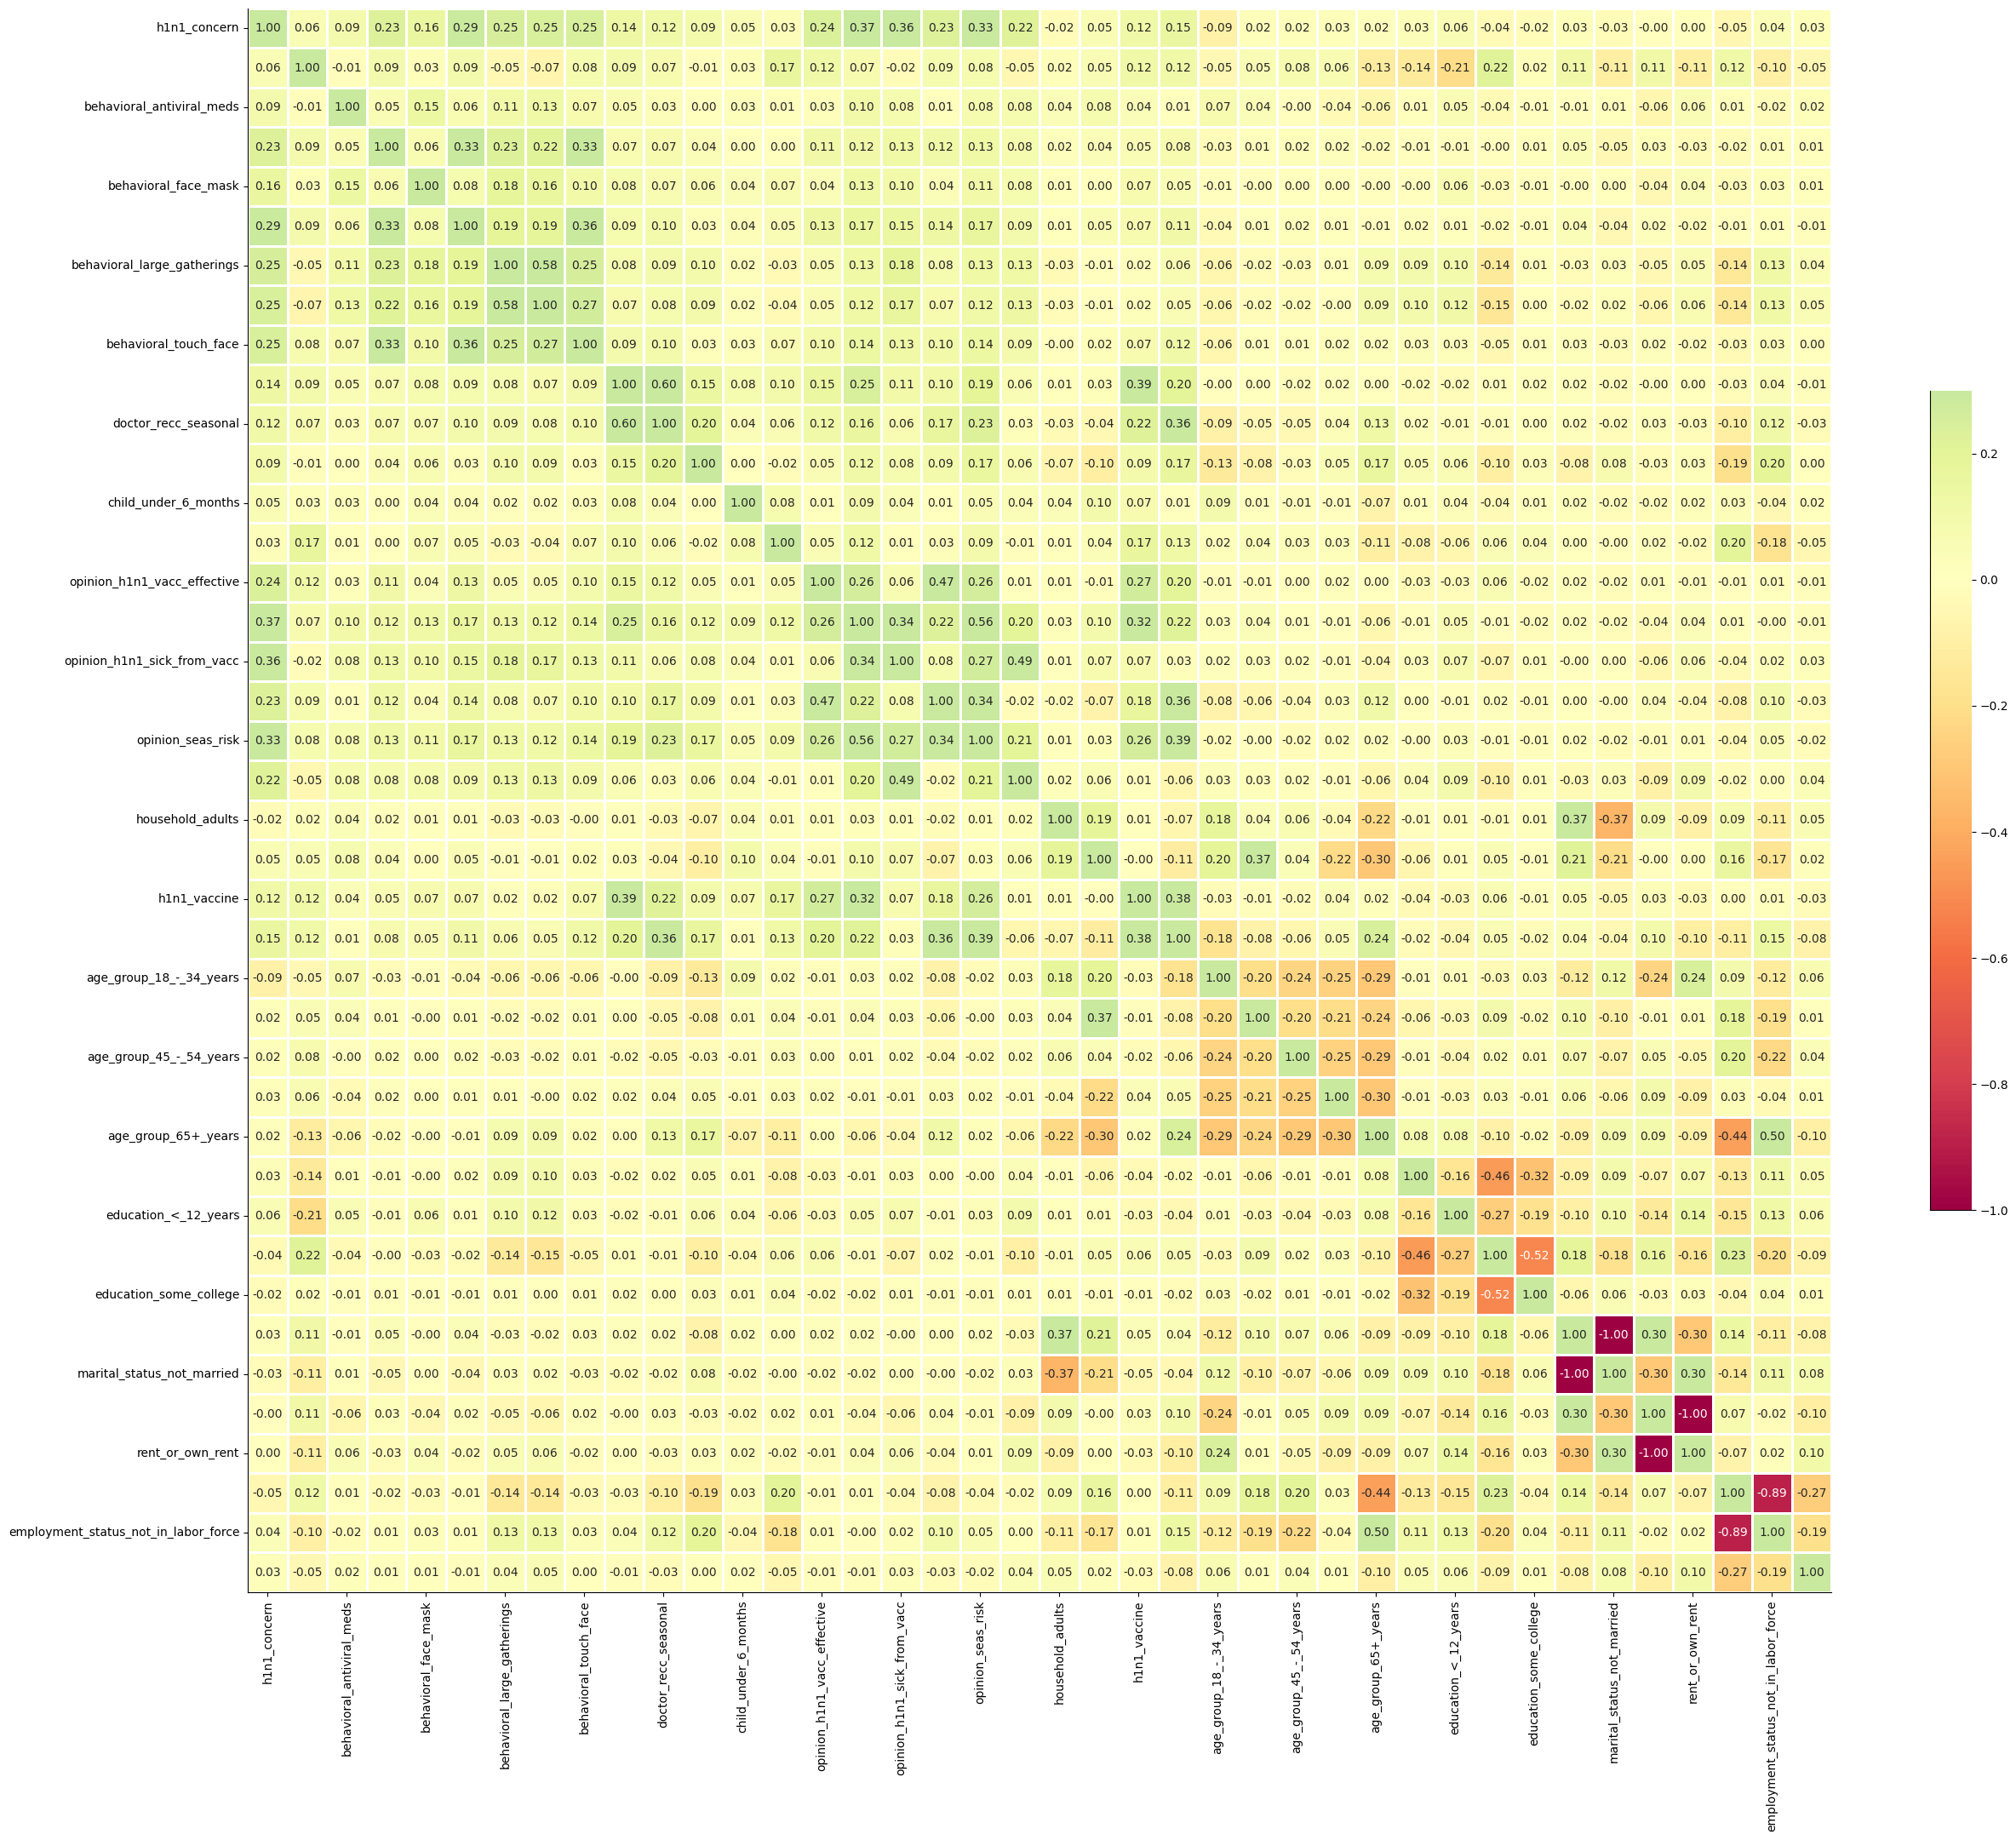

In [ ]:
# corr = data.corr()
# g = sns.heatmap(corr,  vmax=.3, center=0,
#             square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
# sns.despine()
# g.figure.set_size_inches(30,25)
    
# plt.show()

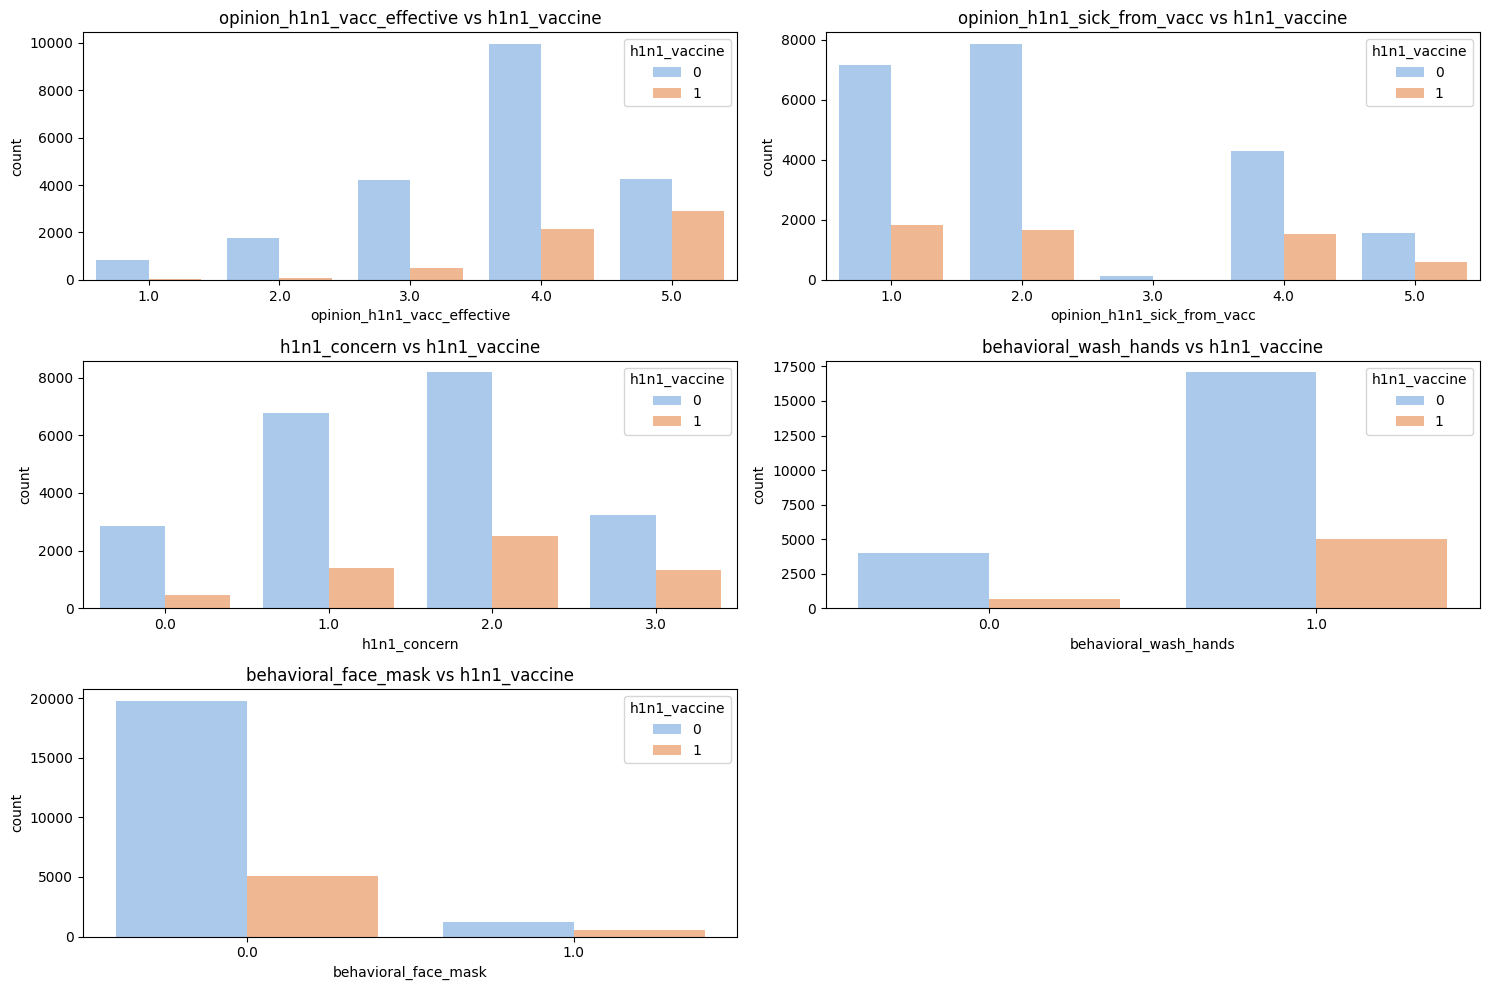

In [ ]:
# plt.figure(figsize=(15, 10))

# features = [
#     'opinion_h1n1_vacc_effective',
#     'opinion_h1n1_sick_from_vacc',
#     'h1n1_concern',
#     'behavioral_wash_hands',
#     'behavioral_face_mask'
# ]

# for i, col in enumerate(features, 1):
#     plt.subplot(3, 2, i)
#     sns.countplot(
#         data=data,
#         x=col,
#         hue='h1n1_vaccine',
#         palette='pastel'
#     )
#     plt.title(f'{col} vs h1n1_vaccine')

# plt.tight_layout()
# plt.show()


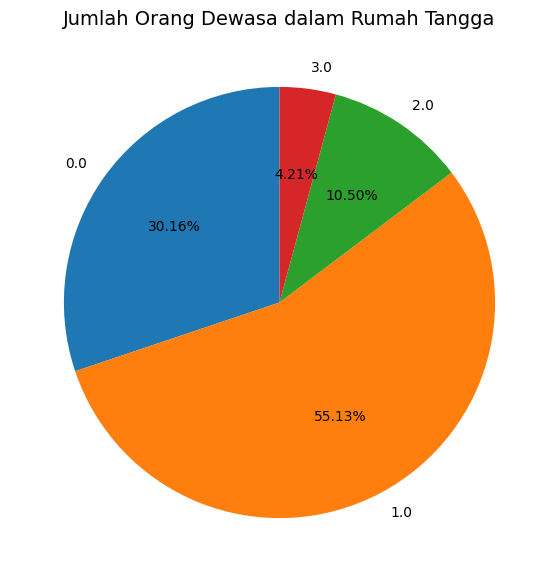

In [ ]:
# adult_counts = data['household_adults'].value_counts().sort_index()
# plt.figure(figsize=(7, 7))
# plt.pie(
#     adult_counts,
#     labels=adult_counts.index,
#     autopct='%1.2f%%',
#     startangle=90
# )

# plt.title('Jumlah Orang Dewasa dalam Rumah Tangga', fontsize=14)
# plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_9112\1078033937.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="behavioral_antiviral_meds", data=data, palette="pastel")
C:\Users\asus\AppData\Local\Temp\ipykernel_9112\1078033937.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="behavioral_avoidance", data=data, palette="pastel")
C:\Users\asus\AppData\Local\Temp\ipykernel_9112\1078033937.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="behavioral_face_mask", data=data, palette="pastel")
C:\Users\asus\AppData\Local\Temp\ipyk

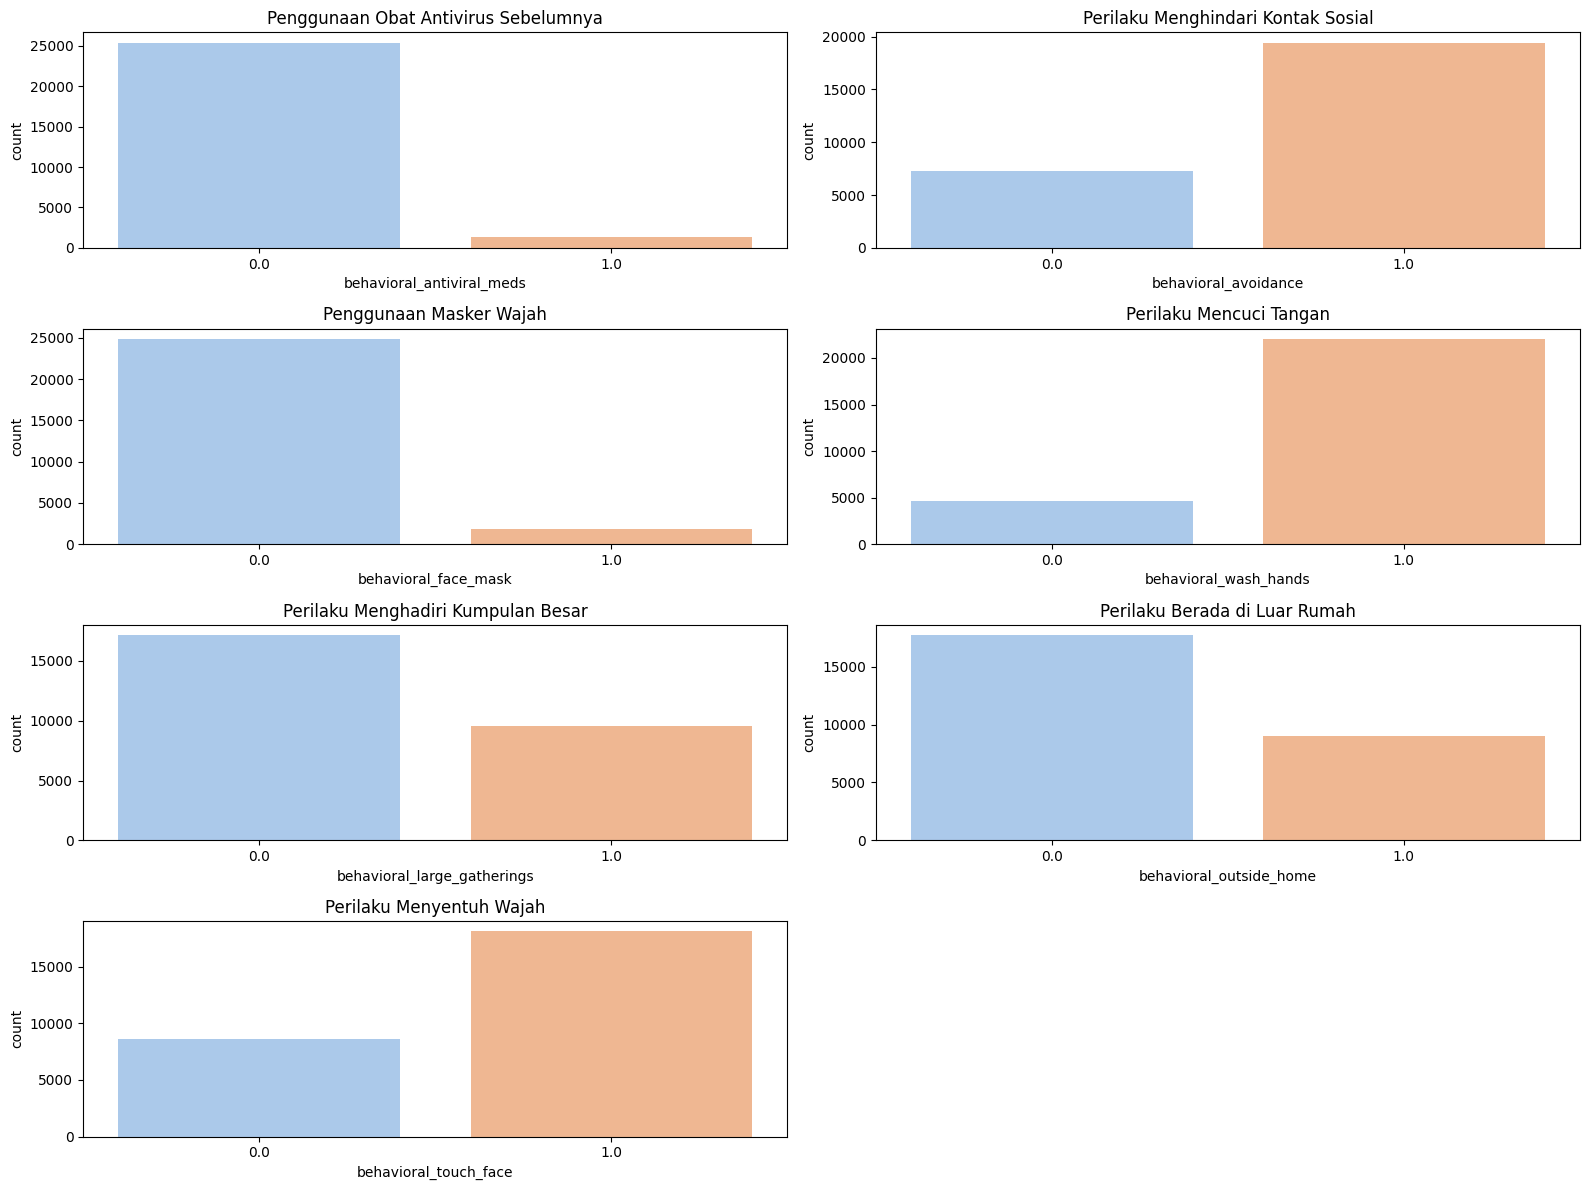

In [ ]:
# plt.figure(figsize=(16, 12))

# plt.subplot(4, 2, 1)
# sns.countplot(x="behavioral_antiviral_meds", data=data, palette="pastel")
# plt.title('Penggunaan Obat Antivirus Sebelumnya')

# plt.subplot(4, 2, 2)
# sns.countplot(x="behavioral_avoidance", data=data, palette="pastel")
# plt.title('Perilaku Menghindari Kontak Sosial')

# plt.subplot(4, 2, 3)
# sns.countplot(x="behavioral_face_mask", data=data, palette="pastel")
# plt.title('Penggunaan Masker Wajah')

# plt.subplot(4, 2, 4)
# sns.countplot(x="behavioral_wash_hands", data=data, palette="pastel")
# plt.title('Perilaku Mencuci Tangan')

# plt.subplot(4, 2, 5)
# sns.countplot(x="behavioral_large_gatherings", data=data, palette="pastel")
# plt.title('Perilaku Menghadiri Kumpulan Besar')

# plt.subplot(4, 2, 6)
# sns.countplot(x="behavioral_outside_home", data=data, palette="pastel")
# plt.title('Perilaku Berada di Luar Rumah')

# plt.subplot(4, 2, 7)
# sns.countplot(x="behavioral_touch_face", data=data, palette="pastel")
# plt.title('Perilaku Menyentuh Wajah')

# plt.tight_layout()
# plt.show()


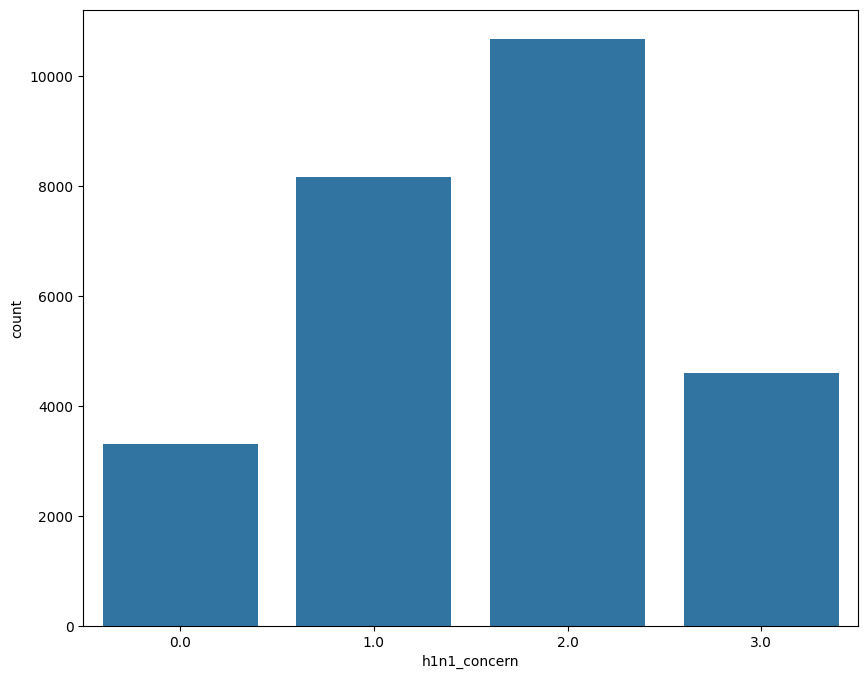

In [ ]:
# #visualisasi distribusi label h1n1_concern

# plt.figure(figsize=(10,8))
# sns.countplot(x="h1n1_concern",data=data)
# plt.show()

In [17]:
x = data.drop("h1n1_vaccine", axis=1)
y = data["h1n1_vaccine"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_smote, y_smote=SMOTE().fit_resample(x_train, y_train)

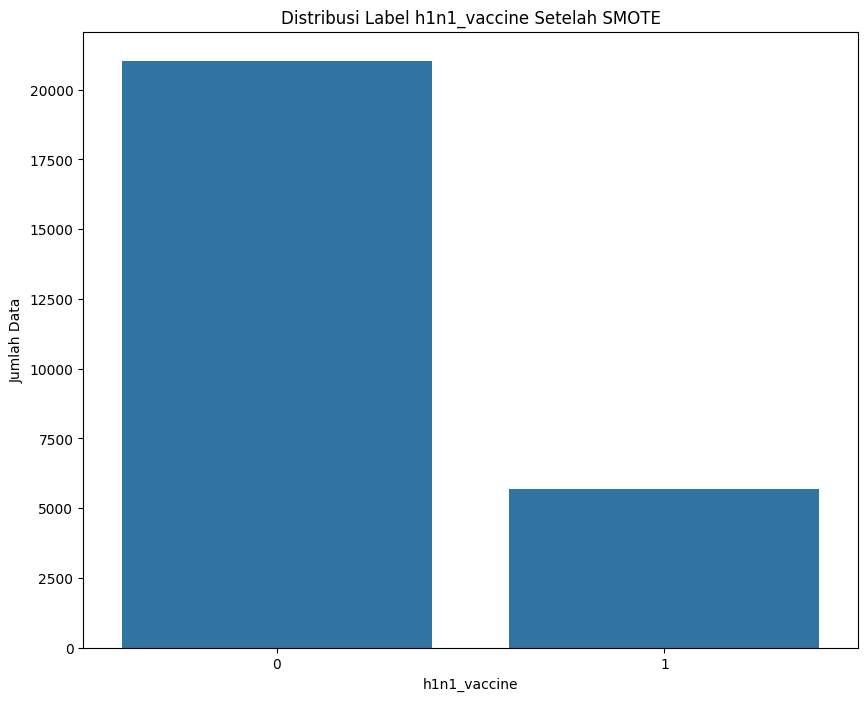

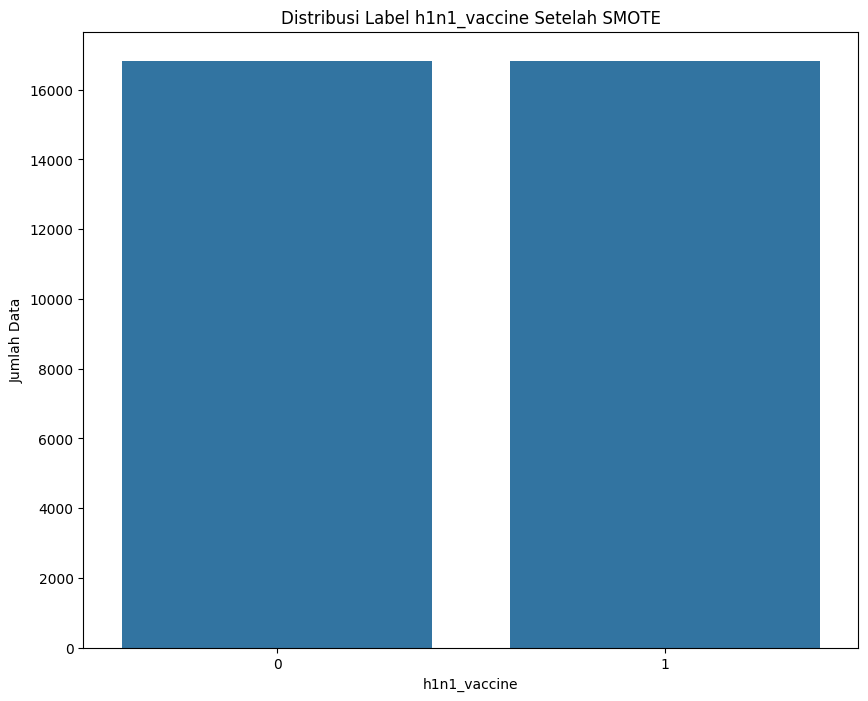

In [69]:
# tampilkan distribusi label
y = pd.DataFrame({
    'h1n1_vaccine': y
})

plt.figure(figsize=(10,8))
sns.countplot(x='h1n1_vaccine', data=y)
plt.title("Distribusi Label h1n1_vaccine Setelah SMOTE")
plt.xlabel("h1n1_vaccine")
plt.ylabel("Jumlah Data")
plt.show()

# tampilkan distribusi label
df_smote = pd.DataFrame({
    'h1n1_vaccine': y_smote
})

plt.figure(figsize=(10,8))
sns.countplot(x='h1n1_vaccine', data=df_smote)
plt.title("Distribusi Label h1n1_vaccine Setelah SMOTE")
plt.xlabel("h1n1_vaccine")
plt.ylabel("Jumlah Data")
plt.show()

In [ ]:

# x = data.drop(columns=['h1n1_vaccine'])
# y = data['h1n1_vaccine']

# # Encoding (wajib sebelum SMOTE)
# x = pd.get_dummies(x, drop_first=True)  
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     x, y, test_size=0.2, random_state=42, stratify=y
# )

# # Sebelum SMOTE
# print("Sebelum SMOTE:")
# print(y_train.value_counts())

# # SMOTE
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)

# # Sesudah SMOTE
# print("\nSesudah SMOTE:")
# print(pd.Series(y_smote).value_counts())


Sebelum SMOTE:
h1n1_vaccine
0    16826
1     4539
Name: count, dtype: int64

Sesudah SMOTE:
h1n1_vaccine
0    16826
1    16826
Name: count, dtype: int64


<h1>Modeling</h1>

In [18]:

# models = {
#     "SVM": (SVC(probability=True, random_state=42),
#         {
#             'C': [0.1, 1, 3, 10],
#             'gamma': ['scale', 0.01, 0.1],
#             'kernel': ['rbf']
#         }
#     ),
#     "Naive Bayes": (GaussianNB(),
#         {
#             'var_smoothing': [1e-9, 1e-8, 1e-7]
#         }
#     ),
#     "Random Forest": (RandomForestClassifier(random_state=42),
#         {
#             'n_estimators': [100, 150, 200, 300],
#             'max_depth': [None, 5, 10, 15],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4],
#             'max_features': ['sqrt', 'log2']
#         }
#     )
# }

# best_params = []
# best_models = {}
# for name, (model, param_grid) in models.items():
#     print(f"Tuning {name}...")
#     search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=5, scoring='f1', n_jobs=-1, random_state=42)
#     search.fit(x_smote, y_smote)
#     best_models[name] = search.best_estimator_
#     best_params.append({
#         'Model': name,
#         'Best Parameters': search.best_params_,
#         'Best CV F1-Score': search.best_score_
#     })

# df_best_params = pd.DataFrame(best_params)
# df_best_params

In [ ]:
for row in best_params:
    print(f"\nModel: {row['Model']}")
    print("Best Parameters:")
    for param, value in row['Best Parameters'].items():
        print(f"  {param}: {value}")
    print(f"Best CV F1-Score: {row['Best CV F1-Score']:.4f}")


In [ ]:
best_models = {"SVM": SVC(
        kernel='rbf',
        C=10,
        gamma=0.1,
        probability=True,
        random_state=42
    ),

    "Naive Bayes": GaussianNB(
        var_smoothing=1e-09
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42
    )
}


<h1>Evaluasi</h1>

In [20]:
evaluation_results = []
roc_curves = {}
conf_matrices = {}
result = {}


for name, model in best_models.items():
    # Training di data SMOTE
    model.fit(x_smote, y_smote)

    # Testing di data asli
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]  
    result[name] = y_pred

    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr)
    

In [21]:
df_eval = pd.DataFrame(evaluation_results)
df_eval


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,SVM,0.821790,0.586074,0.536283,0.560074,0.813330
1,Naive Bayes,0.701235,0.386230,0.700000,0.497797,0.758937
2,Random Forest,0.846874,0.662162,0.563717,0.608987,0.872517


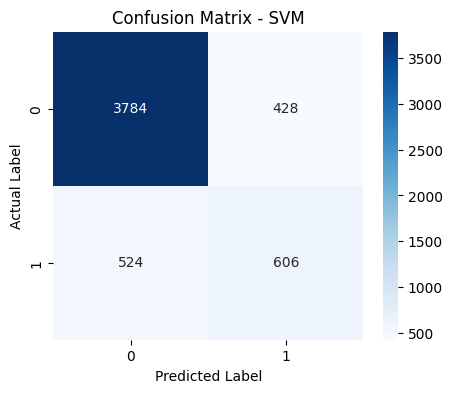


Classification Report - SVM
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4212
           1       0.59      0.54      0.56      1130

    accuracy                           0.82      5342
   macro avg       0.73      0.72      0.72      5342
weighted avg       0.82      0.82      0.82      5342



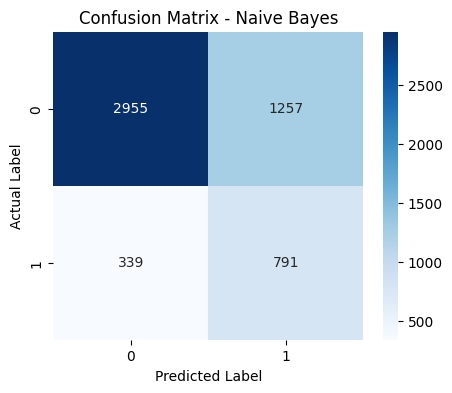


Classification Report - Naive Bayes
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      4212
           1       0.39      0.70      0.50      1130

    accuracy                           0.70      5342
   macro avg       0.64      0.70      0.64      5342
weighted avg       0.79      0.70      0.73      5342



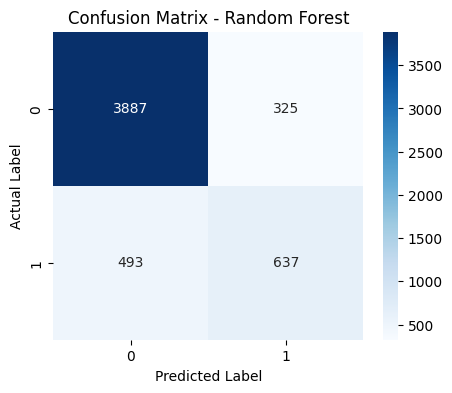


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4212
           1       0.66      0.56      0.61      1130

    accuracy                           0.85      5342
   macro avg       0.77      0.74      0.76      5342
weighted avg       0.84      0.85      0.84      5342



In [22]:
from sklearn.metrics import classification_report

for name, cm in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

    print(f"\nClassification Report - {name}")
    print(classification_report(y_test, result[name]))


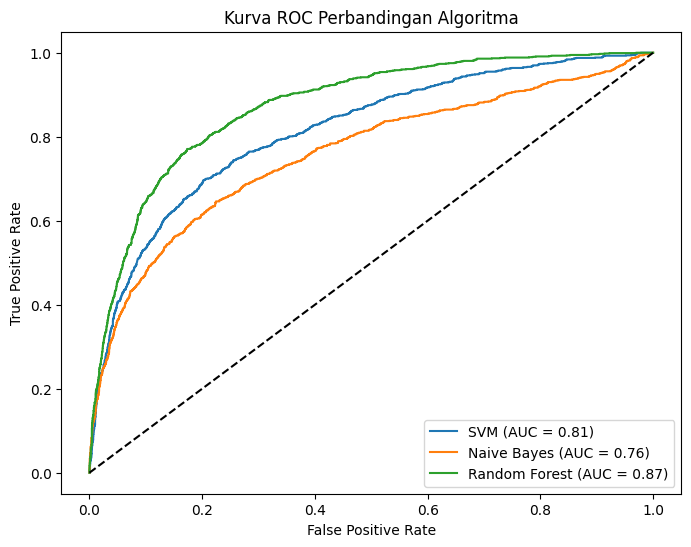

In [23]:
plt.figure(figsize=(8, 6))

for name, (fpr, tpr) in roc_curves.items():
    auc = df_eval[df_eval['Model'] == name]['ROC AUC'].values[0]
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC Perbandingan Algoritma')
plt.legend()
plt.show()


In [24]:
# models = {
#     "SVM": SVC(gamma='scale', probability=True, random_state=42),
#     "Naive Bayes": GaussianNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=130, max_depth=12, random_state=42)
# }

In [25]:
# results = []
# roc_data = {}

# for name, model in models.items():
#     print(f"\n{'='*40}")
#     print(f"MODEL: {name}")
#     print(f"{'='*40}")

#     # Training (data SMOTE)
#     model.fit(x_smote, y_smote)

#     # Testing (data asli)
#     y_pred = model.predict(x_test)
#     y_prob = model.predict_proba(x_test)[:, 1]

#     # Simpan hasil
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
#     })

#     # ===== CONFUSION MATRIX =====
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(5,4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title(f'Confusion Matrix - {name}')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.show()

#     # ===== CLASSIFICATION REPORT =====
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))

#     # ===== ROC =====
#     fpr, tpr, _ = roc_curve(y_test, y_prob)
#     roc_data[name] = (fpr, tpr, roc_auc_score(y_test, y_prob))


In [26]:
# plt.figure(figsize=(8,6))
# for name, (fpr, tpr, auc_score) in roc_data.items():
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Perbandingan ROC Curve')
# plt.legend()
# plt.show()


In [27]:
# df_results = pd.DataFrame(results)
# df_results


In [28]:
# # 1. Load data yang sudah di-SMOTE
# df = pd.read_csv('dataset_h1n1_preprocessing_smote.csv')
# x = df.drop('h1n1_vaccine', axis=1)
# y = df['h1n1_vaccine']

# # 2. Split data (80% Train, 20% Test)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# # 3. Definisi Model
# models = {
#     "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
#     "Naive Bayes": GaussianNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=130, max_depth=12, min_samples_split=8, random_state=42)
# }

# results = []
# roc_plots = {}

# # 4. Training dan Evaluasi
# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
#     })
    
#     fpr, tpr, _ = roc_curve(y_test, y_prob)
#     roc_plots[name] = (fpr, tpr, roc_auc_score(y_test, y_prob))

# # 5. Visualisasi Bar Chart
# df_results = pd.DataFrame(results)
# df_plot = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# plt.figure(figsize=(15, 7))
# sns.set_style("whitegrid")
# ax = sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='viridis')
# plt.title('Perbandingan Performa Model (Setelah SMOTE)', fontsize=16)
# plt.ylim(0, 1.1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# for p in ax.patches:
#     if p.get_height() > 0:
#         ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
#                      ha='center', va='center', xytext=(0, 9), textcoords='offset points')
# plt.show()

# # 6. Visualisasi Kurva ROC
# plt.figure(figsize=(10, 8))
# for name, (fpr, tpr, score) in roc_plots.items():
#     plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {score:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Kurva ROC Perbandingan 3 Algoritma')
# plt.legend(loc="lower right")
# plt.show()

In [29]:
# # Ubah hasil SMOTE ke DataFrame
# x_smote_df = pd.DataFrame(x_smote, columns=x.columns)
# y_smote_df = pd.Series(y_smote, name='h1n1_vaccine')

# # Gabungkan
# data_smote = pd.concat([x_smote_df, y_smote_df], axis=1)

# data_smote.to_csv("dataset_h1n1_preprocessing_smote.csv", index=False)


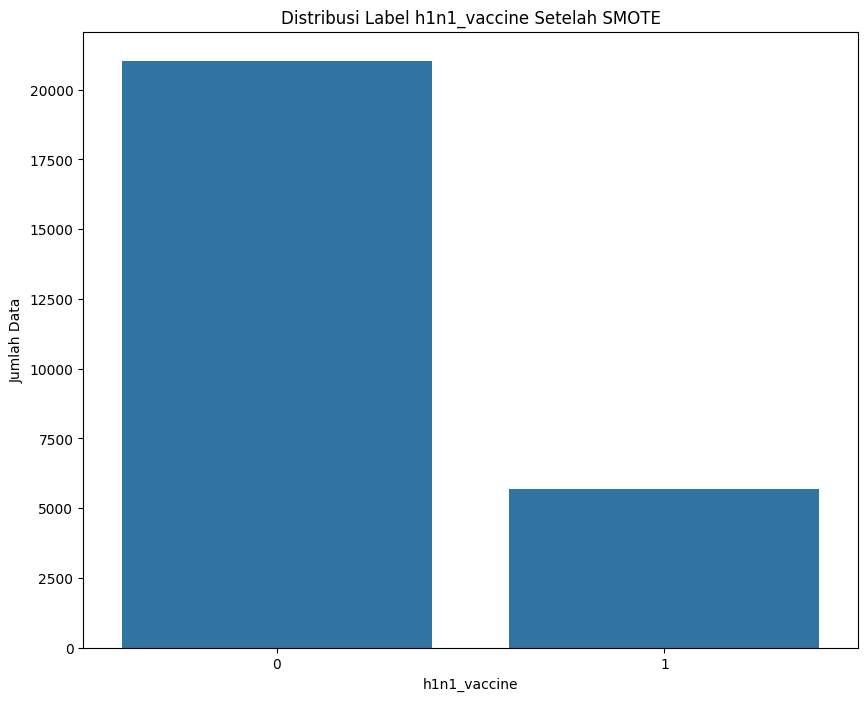

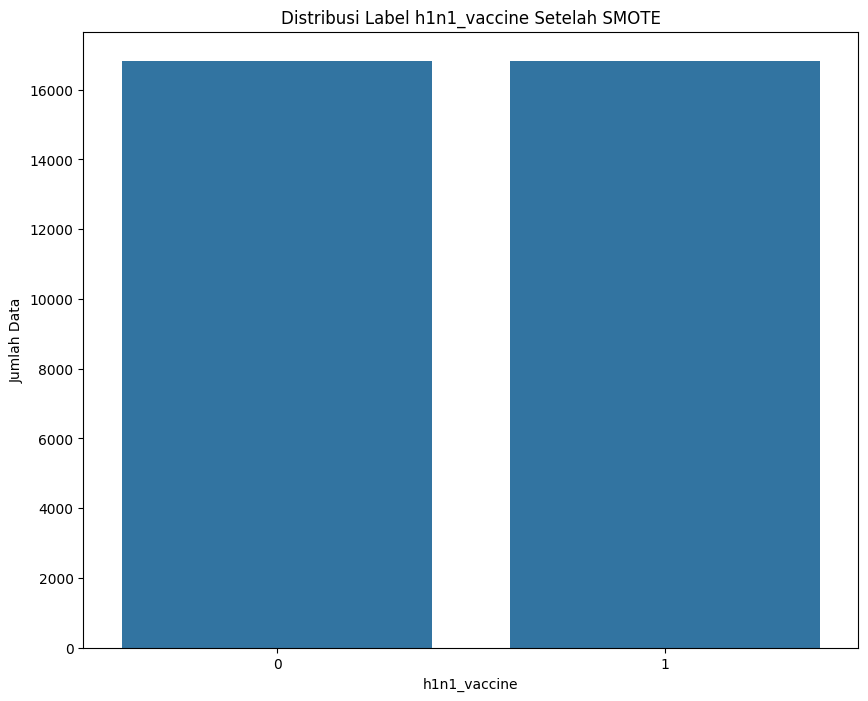

metode biasa

In [31]:


# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# x_train = scaler.fit_transform(x_train)
# x_test  = scaler.transform(x_test)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# x_train = scaler.fit_transform(x_train)
# x_test  = scaler.transform(x_test)

In [32]:
def report(actual,pred):
    acc_score=accuracy_score(actual,pred)
    con_mat=confusion_matrix(actual,pred)
    class_rep=classification_report(actual,pred)
    print("Accuracy of model is", round((acc_score*100),2),'%')
    print('\n ',con_mat)
    print('\n',class_rep)

In [33]:
rf=RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=8, random_state=42)
rf.fit(x_smote,y_smote)
train_rf=rf.predict(x_smote)
test_rf=rf.predict(x_test)
report(y_smote,train_rf)
report(y_test,test_rf)

Accuracy of model is 91.86 %

  [[15650  1171]
 [ 1569 15252]]

               precision    recall  f1-score   support

           0       0.91      0.93      0.92     16821
           1       0.93      0.91      0.92     16821

    accuracy                           0.92     33642
   macro avg       0.92      0.92      0.92     33642
weighted avg       0.92      0.92      0.92     33642

Accuracy of model is 84.29 %

  [[3833  379]
 [ 460  670]]

               precision    recall  f1-score   support

           0       0.89      0.91      0.90      4212
           1       0.64      0.59      0.61      1130

    accuracy                           0.84      5342
   macro avg       0.77      0.75      0.76      5342
weighted avg       0.84      0.84      0.84      5342



In [34]:
nb=GaussianNB()
nb.fit(x_smote, y_smote)
pred_train_nb=nb.predict(x_smote)
pred_tetst_nb=nb.predict(x_test)
report(y_smote, pred_train_nb)
report(y_test, pred_tetst_nb)

Accuracy of model is 75.35 %

  [[11723  5098]
 [ 3195 13626]]

               precision    recall  f1-score   support

           0       0.79      0.70      0.74     16821
           1       0.73      0.81      0.77     16821

    accuracy                           0.75     33642
   macro avg       0.76      0.75      0.75     33642
weighted avg       0.76      0.75      0.75     33642

Accuracy of model is 70.12 %

  [[2955 1257]
 [ 339  791]]

               precision    recall  f1-score   support

           0       0.90      0.70      0.79      4212
           1       0.39      0.70      0.50      1130

    accuracy                           0.70      5342
   macro avg       0.64      0.70      0.64      5342
weighted avg       0.79      0.70      0.73      5342



In [35]:
# svm = SVC(kernel='rbf', C=3, gamma='scale', probability=True)
# svm.fit(x_smote, y_smote)
# train_svm=svm.predict(x_smote)
# test_svm=svm.predict(x_test)
# report(y_smote,train_svm)
# report(y_test,test_svm)

In [36]:
# performa_hasil = []

# models = {
#     "SVM": SVC(kernel='rbf', C=5, gamma='scale', probability=True),
#     "Naive Bayes": GaussianNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=130, max_depth=12, min_samples_leaf=30, min_samples_split=8)
# }

# # # Loop 1: Training SEBELUM SMOTE (Data Asli)
# # for before_smote, model in models.items():
# #     model.fit(x_train, y_train) # Data original
# #     y_pred = model.predict(x_test)
    
# #     performa_hasil.append({
# #         'Model': before_smote,
# #         'Kondisi': 'Sebelum SMOTE',
# #         'Accuracy': accuracy_score(y_test, y_pred),
# #         'Precision': precision_score(y_test, y_pred),
# #         'Recall': recall_score(y_test, y_pred),
# #         'F1-Score': f1_score(y_test, y_pred),
# #         'ROC AUC': roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
# #     })

# # Loop 2: Training SESUDAH SMOTE
# for after_smote, model in models.items():
#     model.fit(x_smote, y_smote) # Data SMOTE
#     y_pred = model.predict(x_test)
    
#     performa_hasil.append({
#         'Model': after_smote,
#         'Kondisi': 'Sesudah SMOTE',
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
#     })

# # Ubah ke DataFrame
# df_compare = pd.DataFrame(performa_hasil)

In [37]:
# df_compare = pd.DataFrame(performa_hasil)
# plt.figure(figsize=(12, 6))
# ax = sns.barplot(data=df_compare,x='Model', y='Accuracy', hue='Kondisi', palette='viridis')
# ax.set_title('Perbandingan Accuracy Sebelum dan Sesudah SMOTE', fontsize=14, fontweight='bold')
# ax.set_ylim(0, 1.05)
# ax.set_xlabel('')
# ax.set_ylabel('Accuracy')

# # Tambahkan label nilai di atas bar
# for p in ax.patches:
#     if p.get_height() > 0:
#         ax.annotate(
#             f"{p.get_height():.2f}",
#             (p.get_x() + p.get_width() / 2., p.get_height()),
#             ha='center',
#             va='bottom',
#             xytext=(0, 6),
#             textcoords='offset points',
#             fontsize=10
#         )

# plt.tight_layout()
# plt.show()


In [38]:
# scaler=StandardScaler()

# # 1. Inisialisasi Model
# models = {
#     "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=100),
#     "Naive Bayes": GaussianNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=8, random_state=100)
# }

# performa_hasil = []

# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# # 2. Proses SEBELUM SMOTE (Menggunakan x_train, y_train asli)
# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     performa_hasil.append({
#         'Model': name,
#         'Kondisi': 'Sebelum SMOTE',
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
        
#     })

# # 3. Proses SESUDAH SMOTE (Menggunakan x_smote, y_smote)
# for name, model in models.items():
#     model.fit(x_smote, y_smote)
#     y_pred = model.predict(x_test) # Evaluasi tetap pada data test asli
#     y_prob = model.predict_proba(x_test)[:, 1]

#     performa_hasil.append({
#         'Model': name,
#         'Kondisi': 'Sesudah SMOTE',
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
        
#     })

# # 4. Konversi ke DataFrame
# df_compare = pd.DataFrame(performa_hasil)

In [39]:
# # 1. Inisialisasi Model
# models = {
#     "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
#     "Naive Bayes": GaussianNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=8, random_state=42)
# }

# performa_hasil = []

# # --- PROSES SEBELUM SMOTE (Menggunakan x_train asli) ---
# for name, model in models.items():
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     performa_hasil.append({
#         'Model': name,
#         'Kondisi': 'Sebelum SMOTE',
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
#     })

# # --- PROSES SESUDAH SMOTE (Menggunakan x_smote asli) ---
# for name, model in models.items():
#     model.fit(x_smote, y_smote)
#     y_pred = model.predict(x_test) # Evaluasi tetap pada data test asli
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     performa_hasil.append({
#         'Model': name,
#         'Kondisi': 'Sesudah SMOTE',
#         'Accuracy': accuracy_score(y_test, y_pred),
#         'Precision': precision_score(y_test, y_pred),
#         'Recall': recall_score(y_test, y_pred),
#         'F1-Score': f1_score(y_test, y_pred),
#         'ROC AUC': roc_auc_score(y_test, y_prob)
#     })




# plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Kurva ROC Perbandingan 3 Algoritma (Tanpa Scaling - Setelah SMOTE)')
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.show()

In [40]:
# metrics = ['Accuracy', 'Recall', 'F1-Score', 'Precision']
# fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# for i, metric in enumerate(metrics):
#     sns.barplot(data=df_compare, x='Model', y=metric, hue='Kondisi', ax=axes[i])
#     axes[i].set_title(f'Perbandingan {metric}', fontsize=14, fontweight='bold')
#     axes[i].set_ylim(0, 1.0)
    
#     # Menambahkan label nilai di atas bar
#     for p in axes[i].patches:
#         axes[i].annotate(format(p.get_height(), '.2f'), 
#                          (p.get_x() + p.get_width() / 2., p.get_height()), 
#                          ha = 'center', va = 'center', 
#                          xytext = (0, 9), textcoords = 'offset points')
# plt.tight_layout()
# plt.show()

In [41]:
# # 1. Menyiapkan Plot
# plt.figure(figsize=(10, 8))
# colors = {'SVM': 'blue', 'Random Forest': 'green', 'Naive Bayes': 'orange'}

# # 2. Iterasi untuk setiap model
# for name, model in models.items():
#     # Pastikan model sudah di-fit menggunakan data SMOTE
#     # model.fit(x_smote, y_smote) # Jalankan ini jika model belum di-fit
    
#     # Mendapatkan probabilitas untuk kelas positif (vaksin = 1)
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     # Menghitung FPR, TPR, dan nilai AUC
#     fpr, tpr, _ = roc_curve(y_test, y_prob)
#     roc_auc = auc(fpr, tpr)
    
#     # Plot kurva untuk masing-masing model
#     plt.plot(fpr, tpr, color=colors[name], lw=2, 
#              label=f'{name} (AUC = {roc_auc:.3f})')

# # 3. Menambahkan Garis Referensi (Random Guess)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# # 4. Pengaturan Grafik
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
# plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
# plt.title('Visualisasi Kurva ROC - Perbandingan 3 Algoritma (Setelah SMOTE)', fontsize=14)
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.show()

In [42]:
# # 1. Definisi Model sesuai parameter yang Anda inginkan
# models = {
#     "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
#     "Random Forest": RandomForestClassifier(n_estimators=130, max_depth=12, min_samples_split=8, random_state=42),
#     "Naive Bayes": GaussianNB()
# }

# results = []

# # 2. Loop Training & Evaluasi pada Data Test
# for name, model in models.items():
#     # Model dilatih menggunakan data hasil SMOTE (x_smote, y_smote)
#     model.fit(x_smote, y_smote)
    
#     # Prediksi dilakukan pada data test asli (x_test)
#     y_pred = model.predict(x_test)
#     y_prob = model.predict_proba(x_test)[:, 1]
    
#     # Simpan semua metrik ke dalam list
#     results.append({
#         'Model': name,
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#         'roc_auc': roc_auc_score(y_test, y_prob)
#     })

# # 3. Transformasi data untuk visualisasi (Melt DataFrame)
# df_results = pd.DataFrame(results)
# df_plot = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# # 4. Membuat Visualisasi
# plt.figure(figsize=(15, 7))
# sns.set_style("whitegrid")

# # Membuat barplot dengan palet warna yang mirip dengan contoh gambar Anda
# ax = sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='viridis')

# # Pengaturan Judul dan Label
# plt.title('Perbandingan Performa Model (Setelah SMOTE)', fontsize=16, pad=20)
# plt.xlabel('Model', fontsize=12)
# plt.ylabel('Score', fontsize=12)
# plt.ylim(0, 1.1)

# # Mengatur legenda agar berada di luar grafik (sebelah kanan)
# plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Menambahkan garis grid horizontal putus-putus
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [43]:
# # 4. Visualisasi Hasil
# plt.figure(figsize=(12, 6))
# # Mengubah format data agar cocok untuk seaborn (tidy format)
# df_plot = cv_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
# df_plot.columns = ['Model', 'Metric', 'Score']

# sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='viridis')

# plt.title('Perbandingan Performa Model (Setelah SMOTE)', fontsize=14)
# plt.ylim(0, 1.1) # Memberi ruang untuk legenda
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [44]:
# import pandas as pd
# from sklearn.metrics import classification_report, accuracy_score

# def get_metrics(y_test, y_pred):
#     report = classification_report(y_test, y_pred, output_dict=True)
#     return {
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "Precision": report["weighted avg"]["precision"],
#         "Recall": report["weighted avg"]["recall"],
#         "F1-Score": report["weighted avg"]["f1-score"]
#     }

# results = []

# results.append({
#     "Algoritma": "Naive Bayes",
#     **get_metrics(y_test, y_pred_nb)
# })

# results.append({
#     "Algoritma": "SVM",
#     **get_metrics(y_test, y_pred_svm)
# })

# results.append({
#     "Algoritma": "Random Forest",
#     **get_metrics(y_test, y_pred_rf)
# })

# comparison_df = pd.DataFrame(results)
# comparison_df


In [45]:
# model_names = ['Naive Bayes', 'SVM', 'Random Forest']
# models = {
#     'Naive Bayes': GaussianNB(),
#     'SVM': SVC(kernel='rbf', probability=True, random_state=42),
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
# }
    
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)


In [46]:
# from sklearn.model_selection import StratifiedKFold, cross_validate
# from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
# scoring = {
#     'accuracy': 'accuracy',
#     'precision': make_scorer(precision_score, pos_label=1),
#     'recall': make_scorer(recall_score, pos_label=1),
#     'f1': make_scorer(f1_score, pos_label=1)
# }



# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# cv_results = []

# for name, model in models.items():
#     scores = cross_validate(
#         model,
#         x,
#         y,
#         cv=cv,
#         scoring=scoring
#     )

#     cv_results.append({
#         'Model': name,
#         'Accuracy': scores['test_accuracy'].mean(),
#         'Precision': scores['test_precision'].mean(),
#         'Recall': scores['test_recall'].mean(),
#         'F1-Score': scores['test_f1'].mean()
#     })


In [47]:
# cv_results_df = pd.DataFrame(cv_results)
# cv_results_df


In [48]:
# from sklearn.metrics import roc_curve, auc

# plt.figure(figsize=(8,6))

# for name, model in models.items():
#     # Pastikan model sudah dilatih
#     model.fit(X_train, y_train)

#     # Ambil skor probabilitas
#     if hasattr(model, "predict_proba"):
#         y_score = model.predict_proba(X_test)[:, 1]
#     else:
#         # Untuk model yang tidak punya predict_proba (fallback)
#         y_score = model.decision_function(X_test)

#     fpr, tpr, _ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)

#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

# # Garis acak
# plt.plot([0,1], [0,1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
# plt.legend()
# plt.show()


In [49]:
# param_grid = {
#     'C': [0.1, 1, 10],
#     'gamma': ['scale', 0.1, 0.01],
#     'kernel': ['rbf'],
#     'class_weight': [None, 'balanced']
# }

In [50]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# svm_model = SVC(random_state=42)

# grid_search = GridSearchCV(
#     estimator=svm_model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train_scaled, y_train)

In [51]:
# best_svm =  grid_search.best_estimator_
# y_pred_svm_tunned = best_svm.predict(X_test_scaled)

In [52]:
# from sklearn.metrics import accuracy_score, classification_report

# print("Best Parameters:", grid_search.best_params_)
# print("Accuracy:", accuracy_score(y_test, y_pred_svm_tunned))
# print(classification_report(y_test, y_pred_svm_tunned))